In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import shap

np.random.seed(12345)

%matplotlib inline

In [2]:
FILE = '/home/weiss/git/isr-data-kd2school/Data_Per_Sec_z_Standardised.csv'

df = pd.read_csv(FILE,
                 sep=';',
                 header=0,
                 # usecols=relevant_columns  # needs to be preproccessed first   
                 )

# df.head(n=30)
# df = df[df['LENGTH'] == 25]  # Sekunde 25
# df[df['VP'] == 1]  # participant number, probably 'VersuchsPerson'

# missing values
# print('NULL values:\n\n',df.isnull().sum())
# df = df.dropna()
# print(df.shape[0])
# print('NULL values:\n\n',df.isnull().sum())
# print(df.shape[0])

In [3]:
labels = df['GOALVSEXP'].unique()
i=0
idx2class = {}
class2idx = {}
for c in labels:
    idx2class[i] = c
    class2idx[c] = i
    i+=1
    
y = df['GOALVSEXP'].map(class2idx)
print('missing val:', y.isna().sum())
print(y.value_counts())
y.head()

missing val: 0
0    5400
1    4600
Name: GOALVSEXP, dtype: int64


0    0
1    0
2    0
3    0
4    0
Name: GOALVSEXP, dtype: int64

In [4]:
X = df.drop(['StudyState', 'VP', 'EXPGR', 'GOALVSEXP', 'LENGTH'], axis=1)
#X.head()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier(max_depth=3, n_estimators=2, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss').fit(X_train, y_train)
predictions = model.predict(X_test)
predictions

array([1, 0, 0, ..., 1, 0, 0])

In [6]:
# Eval 
accuracy_score(predictions, y_test)

0.802

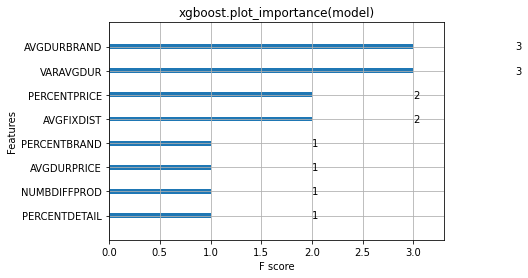

In [7]:
xgb.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [8]:
# https://github.com/ray-project/tune-sklearn/blob/master/examples/xgbclassifier.py

from tune_sklearn import TuneSearchCV

# A parameter grid for XGBoost
params = {
    "min_child_weight": [1, 5, 10],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "max_depth": [3, 4, 5],
}

#xgb = XGBClassifier(
#    learning_rate=0.02,
#    n_estimators=50,
#    objective="binary:logistic",
#    nthread=4,
#    # tree_method="gpu_hist"  # this enables GPU.
#    # See https://github.com/dmlc/xgboost/issues/2819
#)

param_search = TuneSearchCV(
    model,
    param_distributions=params,
    n_trials=3,
    early_stopping=True,
    # use_gpu=True # Commented out for testing on github actions,
    # but this is how you would use gpu
)

param_search.fit(X_train, y_train)
print(param_search.best_params_)
print(param_search.cv_results_)

early_stopping is enabled but max_iters = 1. To enable partial training, set max_iters > 1.
tune-sklearn implements incremental learning for xgboost models following this: https://github.com/dmlc/xgboost/issues/1686. This may negatively impact performance. To disable, set `early_stopping=False`.


{'min_child_weight': 10, 'gamma': 1.0, 'subsample': 1.0, 'colsample_bytree': 0.8, 'max_depth': 5}
{'params': [{'min_child_weight': 10, 'gamma': 1.0, 'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 5}, {'min_child_weight': 10, 'gamma': 1.0, 'subsample': 1.0, 'colsample_bytree': 0.8, 'max_depth': 5}, {'min_child_weight': 10, 'gamma': 0.5, 'subsample': 1.0, 'colsample_bytree': 0.8, 'max_depth': 4}], 'split0_test_score': array([0.869375, 0.921875, 0.860625]), 'split1_test_score': array([0.913125, 0.92875 , 0.8875  ]), 'split2_test_score': array([0.91875 , 0.936875, 0.888125]), 'split3_test_score': array([0.91    , 0.939375, 0.883125]), 'split4_test_score': array([0.888125, 0.9225  , 0.8825  ]), 'mean_test_score': array([0.899875, 0.929875, 0.880375]), 'std_test_score': array([0.01845349, 0.00719592, 0.01012886]), 'rank_test_score': array([2, 1, 3], dtype=int32), 'time_total_s': array([8.18471241, 8.36361337, 6.76673627]), 'training_iteration': array([1, 1, 1]), 'param_min_child_wei

In [34]:
# https://docs.ray.io/en/latest/tune/tutorials/tune-xgboost.html

from ray import tune
from ray.tune.integration.xgboost import TuneReportCheckpointCallback

def train_xgb(config):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Build input matrices for XGBoost
    train_set = xgb.DMatrix(X_train, label=y_train)
    test_set = xgb.DMatrix(X_test, label=y_test)
    # Train the classifier
    results = {}
    xgb.train(
     config,
     train_set,
     evals=[(test_set, "eval")],
     evals_result=results,
     verbose_eval=False)
    # Return prediction accuracy
    accuracy = 1. - results["eval"]["error"][-1]
    tune.report(mean_accuracy=accuracy, done=True)


config = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"],
    "max_depth": tune.randint(1, 9),
    "min_child_weight": tune.choice([1, 2, 3]),
    "subsample": tune.uniform(0.5, 1.0),
    "eta": tune.loguniform(1e-4, 1e-1)
}
analysis = tune.run(train_xgb,
                    metric="mean_accuracy",
                    mode="max",
                    resources_per_trial={"cpu": 1},
                    config=config,
                    num_samples=10,
                    log_to_file=True,
                    progress_reporter=tune.progress_reporter.JupyterNotebookReporter(overwrite=True))


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,acc,iter,total time (s)
train_xgb_3a737_00000,TERMINATED,,0.000733979,5,1,0.701191,0.946,1,29.0152
train_xgb_3a737_00001,TERMINATED,,0.0924537,5,3,0.612857,0.967,1,29.1788
train_xgb_3a737_00002,TERMINATED,,0.00521841,3,3,0.914095,0.7895,1,18.2144
train_xgb_3a737_00003,TERMINATED,,0.0093546,6,1,0.675116,0.9645,1,32.4667
train_xgb_3a737_00004,TERMINATED,,0.0323319,1,1,0.90501,0.7135,1,10.0987
train_xgb_3a737_00005,TERMINATED,,0.00279223,3,2,0.679798,0.795,1,17.9518
train_xgb_3a737_00006,TERMINATED,,0.0303749,1,2,0.781657,0.7135,1,10.9519
train_xgb_3a737_00007,TERMINATED,,0.00579783,6,3,0.594954,0.968,1,31.8133
train_xgb_3a737_00008,TERMINATED,,0.00120125,8,3,0.714134,0.9785,1,17.221
train_xgb_3a737_00009,TERMINATED,,0.000818942,2,1,0.545107,0.775,1,8.67734


2021-10-31 21:54:08,810	INFO tune.py:617 -- Total run time: 35.58 seconds (35.44 seconds for the tuning loop).


In [35]:

print("Best hyperparameters found were: ", analysis.best_config)

Best hyperparameters found were:  {'objective': 'binary:logistic', 'eval_metric': ['logloss', 'error'], 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.7141343612267175, 'eta': 0.0012012503979470456}


[2021-10-31 22:04:46,440 E 34113 34803] direct_task_transport.cc:556: The worker failed to receive a response from the local raylet. This is most likely because the local raylet has crahsed.
2021-10-31 22:04:46,546	WARNING worker.py:1227 -- The autoscaler failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/ray/autoscaler/_private/monitor.py", line 331, in run
    self._run()
  File "/usr/lib/python3.9/site-packages/ray/autoscaler/_private/monitor.py", line 220, in _run
    self.update_load_metrics()
  File "/usr/lib/python3.9/site-packages/ray/autoscaler/_private/monitor.py", line 176, in update_load_metrics
    response = self.gcs_node_resources_stub.GetAllResourceUsage(
  File "/usr/lib/python3.9/site-packages/grpc/_channel.py", line 946, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/usr/lib/python3.9/site-packages/grpc/_channel.py", line 849, in _end_unary_response_blocking
    raise _I

In [18]:
import os

def get_best_model_checkpoint(analysis):
    best_bst = xgb.Booster()
    best_bst.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))
    accuracy = 1. - analysis.best_result["eval-error"]
    print(f"Best model parameters: {analysis.best_config}")
    print(f"Best model total accuracy: {accuracy:.4f}")
    return best_bst

best_bst = get_best_model_checkpoint(analysis)

2021-10-31 21:25:54,526	ERROR experiment_analysis.py:309 -- No checkpoints have been found for trial train_xgb_f0199_00003.


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [12]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(x_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

AttributeError: module 'shap' has no attribute 'Explainer'